# BETH Dataset Anomaly Detection
 *Mattia Tamiazzo, 2090214*


In this notebook we will present some Machine Learning methods for the detection of cybersecurity attacks using anomaly detection techniques.

The dataset that has been used for the analysis is BETH Dataset (https://www.kaggle.com/datasets/katehighnam/beth-dataset), that contains real cybersecurity events collected from 23 honeypots.

In the first part of the notebook we will analyse the content of the dataset, performing feature selection and mapping, and we will define the models evaluation and training strategies.

In the second part of the notebook, we will present the chosen models and we will perform their training and evaluation.

## Dataset import

BETH Dataset contains two types of data: the biggest part (\~1.1 million samples) is data from honeypots' system call logs, while the second smaller part (\~300 samples) is composed by network traffic logs. Since the number of samples for the second part is difficult to be used for the training and evaluation of a ML classifier, we will analyse only the first part of the dataset.

The entire dataset is downloaded from https://www.kaggle.com/ as csv files, which are imported in DataFrames using *pandas*.

N.B.: for the dataset download it is necessary to use you own kaggle's .json authentication file, with name kaggle.json; you can follow [this guide](https://www.kaggle.com/discussions/general/74235) to create and download it.

In [ ]:
# Import kaggle authentication file for the dataset downloading.
from google.colab import files

# Choose the kaggle's .json authentication file kaggle.json
files.upload()

In [ ]:
!pip install --upgrade scikit-learn==1.2.2 --quiet
!pip install umap-learn --quiet
!pip install -q kaggle

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.2/88.2 kB 1.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 10.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [ ]:
# Download, import and unzip the dataset.
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d 'katehighnam/beth-dataset'
!unzip beth-dataset.zip

 91% 36.0M/39.8M [00:01<00:00, 31.0MB/s]
100% 39.8M/39.8M [00:01<00:00, 21.9MB/s]
Archive:  beth-dataset.zip
  inflating: labelled_2021may-ip-10-100-1-105-dns.csv  
  inflating: labelled_2021may-ip-10-100-1-105.csv  
  inflating: labelled_2021may-ip-10-100-1-186-dns.csv  
  inflating: labelled_2021may-ip-10-100-1-186.csv  
  inflating: labelled_2021may-ip-10-100-1-26-dns.csv  
  inflating: labelled_2021may-ip-10-100-1-26.csv  
  inflating: labelled_2021may-ip-10-100-1-4-dns.csv  
  inflating: labelled_2021may-ip-10-100-1-4.csv  
  inflating: labelled_2021may-ip-10-100-1-95-dns.csv  
  inflating: labelled_2021may-ip-10-100-1-95.csv  
  inflating: labelled_2021may-ubuntu-dns.csv  
  inflating: labelled_2021may-ubuntu.csv  
  inflating: labelled_testing_data.csv  
  inflating: labelled_training_data.csv  
  inflating: labelled_validation_data.csv  


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import itertools

from sklearn.covariance import EllipticEnvelope
from sklearn.neighbors import LocalOutlierFactor
from sklearn.decomposition import PCA
from sklearn.ensemble import IsolationForest
from sklearn.kernel_approximation import Nystroem
from sklearn.linear_model import SGDOneClassSVM

from sklearn.pipeline import make_pipeline, Pipeline

from sklearn import metrics

from sklearn.preprocessing import StandardScaler, MinMaxScaler, Normalizer

from tensorflow import keras
from keras import layers

import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Create pandas dataframes for training, validation and test sets from csv files.
train_df = pd.read_csv('labelled_training_data.csv')
test_df = pd.read_csv('labelled_testing_data.csv')
validation_df = pd.read_csv('labelled_validation_data.csv')

## Feature selection and mapping

In this section we will perform feature selection to reduce the data dimensionality and some data transformation to make features more reasonable, similiarly as done in the notebook https://www.kaggle.com/code/br0kej/beth-eda-processing-and-model-training.

Two functions are defined for data prepreprocessing, which are used to build the training, validation and test sets in their original version or containing only inliers, useful for the training of some models.

The considered target labels will be the mapping to 1/-1 of the 'sus' labels of the original data, which represent whether one record is classified or not as unusual activity (outlier). In this analysis we will ignore the 'evil' label, since it marks malicious external presence not inherent to the system, as they are generated from a data distribution not seen during training.

In [ ]:
# Mapping of the original features to a more reasonable set of features.
def prepare_dataset(df):
  # Map process ID to OS process(0) vs user process(1).
  df['processId'] = df['processId'].map(lambda x: 0 if x in [0, 1, 2] else 1)
  # Map parent process ID to OS process(0) vs user process(1).
  df['parentProcessId'] = df['parentProcessId'].map(lambda x: 0 if x in [0, 1, 2] else 1)
  # Map user ID to OS(0) vs user(1).
  df['userId'] = df['userId'].map(lambda x: 0 if x < 1000 else 1)
  # Map mount access to folder mnt/ (all non-OS users)(0) vs elsewhere(1).
  df['mountNamespace'] = df['mountNamespace'].map(lambda x: 0 if x == 4026531840 else 1)
  # eventId remains unchanged.
  df['eventId'] = df['eventId']
  # Map return value to success(0) vs success with returned value(1) vs success with error(2).
  df['returnValue'] = df['returnValue'].map(lambda x: 0 if x == 0 else (1 if x > 0 else 2))

  # The returned set of feature is a dataframe with 7 columns.
  X = df[['processId', 'parentProcessId', 'userId', 'mountNamespace', 'eventId', 'argsNum', 'returnValue']].copy()
  # The returned labels dataframe is the column 'sus', which is mapped to value -1 for outliers and 1 for inliers.
  y = df['sus'].copy()
  y[y == 1] = -1 # outliers
  y[y == 0] = 1 # inliers

  return X, y

# Function to remove outliers from the dataframe X w.r.t. labels y.
def remove_outliers(X, y):
  X_inliers = X[y == 1].copy()
  return X_inliers.reset_index(drop=True)

In [ ]:
# Prepare the training, validation and test sets.
X_train, y_train = prepare_dataset(train_df)
X_val, y_val = prepare_dataset(validation_df)
X_test, y_test = prepare_dataset(test_df)

# Prepare the traning and validation sets containing only inliers.
X_train_inliers = remove_outliers(X_train, y_train)
X_val_inliers = remove_outliers(X_val, y_val)

# Estimated contamination factor, used by sklearn classifiers.
outliers_fraction = 0.05

# Lists for containing classifiers' names, test set predictions and computation times.
model_names_list = []
y_pred_list = []
times_list = []

## Model evaluation

In this section we will define the evaluation methods for each trained model. The first function prints accuracy, precision, recall and F1-score considering the model prediction against the original true labels.

Moreover, each model is analysed taking into account the confusion matrix of its predictions and the classifier's ROC (Receiver Operating Characteristic) curve, which plots the True Positive Rate (TPR) against the False Positive Rate (FPR). Using this type of evaluation, we can balance also the number of false positives and false negatives.

The final model evaluation and comparison is performed considering the AUC ROC score (Area Under the ROC Curve); this score must be maximized to reach the perfect classifier (with AUC ROC score equal to 1).

In [ ]:
# Function to visualize accuracy, precision, recall and F1-score based on true and predicted labels.
def metric_print(y_true, y_pred):
  accuracy = metrics.accuracy_score(y_true, y_pred)
  precision = metrics.precision_score(y_true, y_pred, average='weighted')
  recall = metrics.recall_score(y_true, y_pred, average='weighted')
  f_score = metrics.f1_score(y_true, y_pred, average='weighted')

  print(f'Accuracy: {accuracy}')
  print(f'Precision: {precision}')
  print(f'Recall: {recall}')
  print(f'F1-score: {f_score}')

# This function returns a metrics.RocCurveDisplay object to plot an estimator's ROC curve, starting from its predictions.
def roc_plot(y, pred, estimator_name):
  fpr, tpr, thresholds = metrics.roc_curve(y, pred)
  roc_auc = metrics.roc_auc_score(y, pred)
  return metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name=estimator_name)

# This function returns a metrics.ConfusionMatrixDisplay object to plot an estimator's confusion matrix, starting from its predictions.
def confusion_matrix(y, pred, estimator_name):
  cm = metrics.confusion_matrix(y, pred)
  cm_display = metrics.ConfusionMatrixDisplay(cm, display_labels=['Outliers', 'Inliers'])
  return cm_display

# Function to plot both the ROC curve and confusion matrix for an estimator.
def cm_roc_plot(y, pred, estimator_name):
  fig, ax = plt.subplots(1, 2, figsize=(15, 5))
  roc = roc_plot(y, pred, estimator_name).plot(ax=ax[0], linewidth=2.5)
  cm = confusion_matrix(y, pred, estimator_name).plot(ax=ax[1])
  fig.suptitle(estimator_name)
  plt.show()

## Training strategies

This set of helper functions are used for the training of most of the evaluated model.

In general, the adopted strategy for training and hyperparameters tuning consists in the automatic search for the the best set of parameters, using the training set during the learning phase and the validation set to maximize the model performances.
Unfortunately, this strategy could not be applied for every type of classifier, because some of them took an important amount of time to be trained.

In some cases, since the training/validation and test samples have different sources and distributions, the best found sets of hyperparameters result very good on the validation data, but with poor performances on the test set.
However, we conducted a manual search for parameters with better performances, and we will train these models using them.  

In [ ]:
# This function takes a dictionary with parameter names for sklearn models' as keys, and lists of parameters as values.
# It allows to build a list of dictionaries, combining each value for each parameter, for parameter selection.
def params_comb(params_dict):
  hyperp_list = []
  for hp in itertools.product(*params_dict.values()):
      hp_dict={}
      i = 0
      for key in params_dict.keys():
        hp_dict[key] = hp[i]
        i += 1
      hyperp_list.append(hp_dict)
  return hyperp_list

In [ ]:
# Function to explore model performances using different sets of parameters.
# Starting from a dictionary of parameters, one model is trained and evaluate using the F1-score on the validation set.
# The best set of parameters is returned. Labels for the training set are not required, since unsupervised learning is used.
def find_best_params(model, params, X_train, X_val, y_val, model_name=''):
  # Build every possible parameters combination starting from the input dictionary.
  params_list = params_comb(params)
  # F1-scores list on the validation set.
  f1_list = []
  print(f'Training {model_name}')
  print(f"{'Parameters' : <60}{'F1-score': <20}")

  # par is a possible combination of parameters.
  for par in params_list:
    # The current set of parameters is applied to the model, which is trained using X_train.
    model.set_params(**par)
    model.fit(X_train)

    # The predictions for the validation set are computed.
    y_val_pred = pd.Series(model.predict(X_val))

    # The F1-score is computed on the validation set and stored.
    f_score = metrics.f1_score(y_val, y_val_pred, average='weighted')
    print(f"{str(par) : <60}{f_score : <20}")
    f1_list.append(f_score)

  # Select and return the set of parameters with the highest F1-score on the validation set.
  index = np.argmax(np.array([f1_list]))
  print(f'Best parameters: {params_list[index]}')
  return params_list[index]

In [ ]:
# This function fits an sklearn classifier on X_train using parameters params.
# It returns the trained model, validation and test sets' predictions, and training time.
def sklearn_fit_predict(model, X_train, params, X_val, X_test, model_name=''):
  print(f'Training {model_name} with parameters {params}')
  # Apply the input parameters to the model.
  model.set_params(**params)

  # Fit the model on the training set, computing the training time.
  start = time.time()
  model.fit(X_train)
  duration = time.time() - start
  print(f'Training completed in {duration} seconds')

  # Predict labels for validation and test sets.
  y_val_pred = pd.Series(model.predict(X_val))
  y_test_pred = pd.Series(model.predict(X_test))

  return model, y_val_pred, y_test_pred, duration

## Model analysis

In general, for the outlier detection we adopted Machine Learning methods which belong to the Unsupervised Learning techniques. Since the dataset has been manually labeled, this approach allows the prediction of future attacks in a more efficient and effective way.

The validation and test sets has been used with their original labels for the evaluation of each classifier.

### Elliptic Envelope

This method allows to detect anomalies in a Gaussian distributed dataset. The entire training set is used for the model learning phase, setting before the outliers rate (contamination). This classifier assumes that the training data have been drawn from a normal distribution.

The trained model is then used to classify samples from the validation and training sets.

In [ ]:
model_name = 'Elliptic Envelop'
model_names_list.append(model_name)
# Since the classifier cannot use different hyperparameters, an empty dictionary is passed for the training.
best_params = {}

ellenv = EllipticEnvelope(contamination=outliers_fraction, random_state=0)

# Train the model and predict labels for the validation and test sets.
ellenv, y_val_ellenv, y_test_ellenv, time_ellenv = sklearn_fit_predict(ellenv, X_train, best_params, X_val, X_test, model_name)
y_pred_list.append(y_test_ellenv)
times_list.append(time_ellenv)

Training Elliptic Envelop with parameters {}
Training completed in 86.14897394180298 seconds


In [ ]:
# Print the metrics for the validation set.
metric_print(y_val, y_val_ellenv)

Accuracy: 0.9632740108061196
Precision: 0.991704693059341
Recall: 0.9632740108061196
F1-score: 0.9772380109081575


In [ ]:
# Print the metrics for the test set.
metric_print(y_test, y_test_ellenv)

Accuracy: 0.09260347044722095
Precision: 0.4464399187425683
Recall: 0.09260347044722095
F1-score: 0.01693296823601805


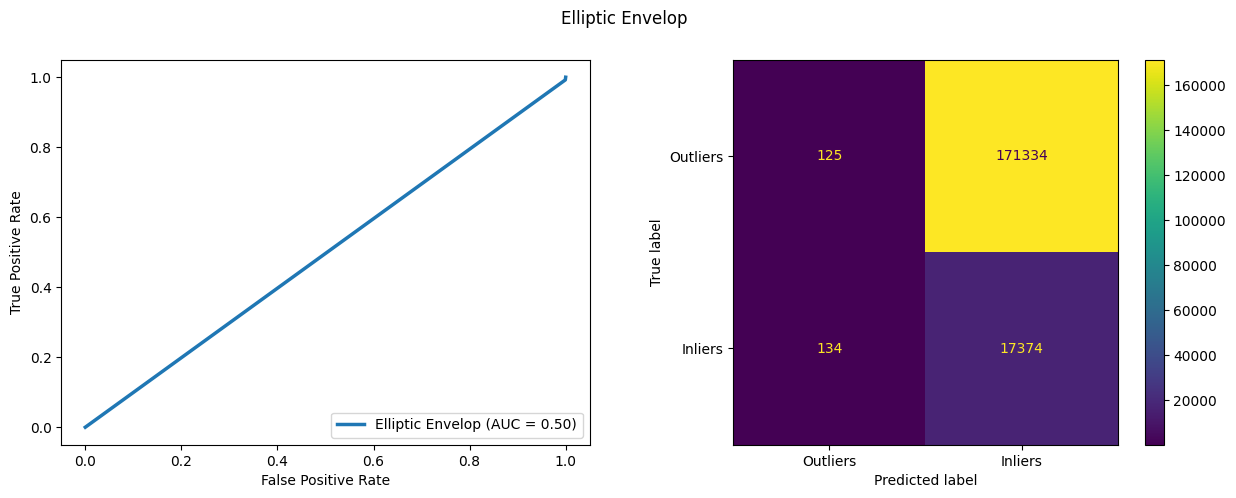

In [ ]:
# Plot and display ROC curve and confusion matrix.
cm_roc_plot(y_test, y_test_ellenv, model_name)

The model has been trained in a medium amount of time. Performances seems great on the validation set; however, as we can see from the ROC curve plot, on the test set performances become really low, and the model results as precise as a random classifier.

Training and test sets has been drawn from two different probability distribution, and this is probably the cause of these bad performances.

### Local Outlier Factor

The Local Outlier Factor (LOF) algorithm is an unsupervised method to perform anomaly detection. Given a data point, this algorithm computes its local density deviation with respect to its neighbors. Samples with a substantial lower density than their neighbors are considered outliers.

In our analysis, we trained the model on the clean training dataset (outliers are excluded directly by the method, with respect to the contamination factor) and then the classifier is used as novelty detector, to predict new unseen data. In this context, the model should be able to correctly classify outliers, since they has been drawn from a different probability distribution.

In [ ]:
model_name = 'Local Outlier Factor'
model_names_list.append(model_name)
# Since the model takes a large amount of training time, a manual exploration of the hyperparameters has been performed.
best_params = {
    'n_neighbors': 20,
    'leaf_size': 30
}

lof = LocalOutlierFactor(contamination=outliers_fraction, novelty=True)

# Train the model and predict labels for the validation and test sets.
lof, y_val_lof, y_test_lof, time_lof = sklearn_fit_predict(lof, X_train, best_params, X_val, X_test, model_name)
y_pred_list.append(y_test_lof)
times_list.append(time_lof)

Training Local Outlier Factor with parameters {'n_neighbors': 20, 'leaf_size': 30}
Training completed in 2075.7135787010193 seconds


In [ ]:
# Print the metrics for the validation set.
metric_print(y_val, y_val_lof)

Accuracy: 0.9954859843253054
Precision: 0.9932628774480775
Recall: 0.9954859843253054
F1-score: 0.9940546458382578


In [ ]:
# Print the metrics for the test set.
metric_print(y_test, y_test_lof)

Accuracy: 0.9267332391369921
Precision: 0.9582502063111997
Recall: 0.9267332391369921
F1-score: 0.9354405187069172


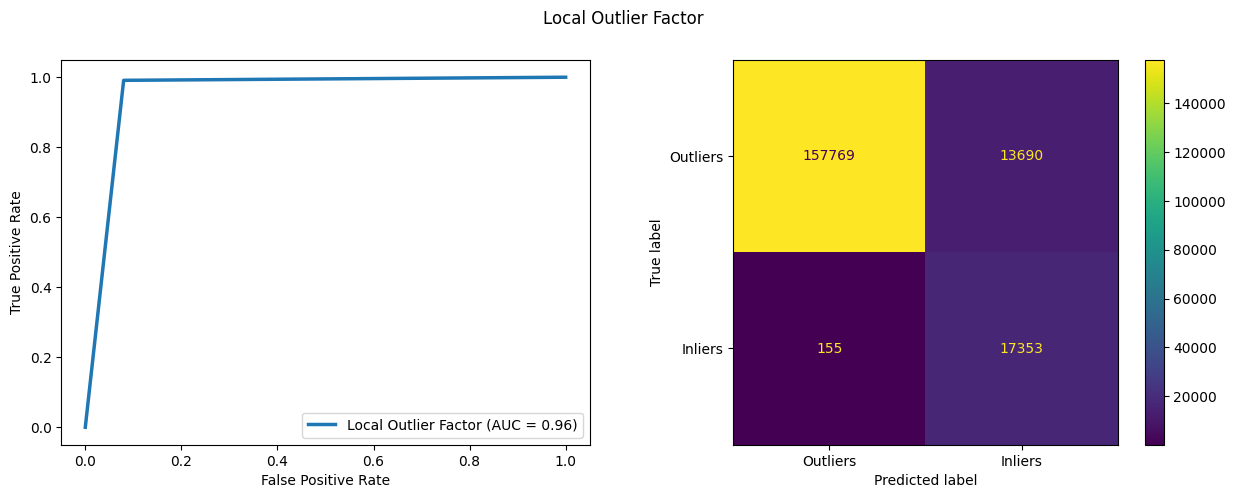

In [ ]:
# Plot and display ROC curve and confusion matrix.
cm_roc_plot(y_test, y_test_lof, model_name)

This method has great performances on both the validation and test data. As shown by the ROC curve plot and the confusion matrix, most of the samples are correctly classified, and the AUC ROC score reaches a high value (~0.96).

However, both the training and the evaluation take a large amount of time, caused by the algorithm exponential complexity. In particular, during our tests, the training phase varied from a minimum of 30 minutes to a maximum of 50 minutes, depending on the initial conditions.

### Principal Component Analysis

Principal Component Analysis allows to reduct data dimensionality while preserving the maximum amount of information. However, this kind of transformation will necessarily cause information loss.

In our analysis, we can apply such method to learn a different representation of the training data, minimizing the amount of reconstruction loss. Then, the model will be used to transform and reconstruct samples from the validation and test sets, causing a larger amount of reconstruction loss for outliers.

In [ ]:
# Class used to instantiate a PCA outlier detector, that contains a pipeline
# which is composed by a StandardScaler and a PCA transformation.
#
# During the training phase, both the scaler and the PCA are trained over the
# training data, then the original samples are reconstructed and a threshold is
# computed considering the reconstruction loss.
#
# During the prediction phase, samples are transformed and reconstructed,
# marking as outliers samples with a reconstruction loss higher than the
# considered threshold.
#
# The class has been built to be compatible with find_best_params and sklearn_fit_predict functions.

class PCA_outlier_detector:

  # Class constructor. The pipeline is built combining the StandardScaler and the
  # PCA transformation, defining the number of pca components (n_components) and
  # the percentage of inliers in the training set (perc).
  # Parameters:
  #   - n_components:   number of components to keep during PCA.
  #   - perc:           percentage of inliers in the training set.
  #   - random_state:   used by PCA for reproducibily.
  def __init__(self, n_components=None, perc=100, random_state=0):
    scaler = StandardScaler()
    pca = PCA(n_components=n_components, random_state=random_state)
    self.pipe = make_pipeline(scaler, pca)
    self.perc = perc

  # Helper function that maps boolean values (Outlier/Not outlier) to 1/-1.
  def _map_results(self, anomalies):
    ret = pd.Series(anomalies)
    return ret.map(lambda x: 1 if x == False else -1)

  # Fit the model on the set of feature X.
  def fit(self, X, y=None):
    self.fit_predict(X)
    return self

  # Fit the model on the set of feature X and return the corresponding prediction labels.
  def fit_predict(self, X, y=None):
    # Scaling and PCA fitting and transformation.
    X_pca = self.pipe.fit_transform(X)
    # Reconstruction of the original samples.
    X_rec = self.pipe.inverse_transform(X_pca)

    # Compute the reconstruction losses and the decision threshold.
    loss = keras.losses.mae(X_rec, X)
    self.threshold = np.percentile(loss, self.perc)

    # Return 1 for inliers and -1 for outliers.
    return self._map_results(loss > self.threshold)

  # Return the predicted labels for X.
  def predict(self, X):
    # Scaling and PCA transformations.
    X_pca = self.pipe.transform(X)
    # Reconstruction of the original samples.
    X_rec = self.pipe.inverse_transform(X_pca)

    # Compute the reconstruction losses.
    loss = keras.losses.mae(X_rec, X)
    # Return 1 for inliers and -1 for outliers.
    return self._map_results(loss > self.threshold)

  # Set parameters for the pipeline, using a dictionary of values.
  # It returns the modified model.
  def set_params(self, **params):
    n_comp = params.get('n_components', None)
    rnd_state = params.get('random_state', None)
    perc = params.get('perc', None)

    pipe_params = {}
    if n_comp != None:
      pipe_params['pca__n_components'] = n_comp
    if rnd_state != None:
      pipe_params['pca__random_state'] = rnd_state
    self.pipe.set_params(**pipe_params)

    if n_comp != None:
      self.perc = perc

    return self

In [ ]:
model_name = 'PCA Outlier Detector'
model_names_list.append(model_name)
# Values for parameters selection.
params = {
    'n_components': [3, 4, 5],
    'perc': [95, 96, 97, 98]
}

pca_od = PCA_outlier_detector(random_state=0)

# Find the hyperparameters with maximum F1-score on the validation set.
best_params = find_best_params(pca_od, params, X_train, X_val, y_val, model_name=model_name)

# Train the model and predict labels for the validation and test sets.
pca_od, y_val_pca, y_test_pca, time_pca = sklearn_fit_predict(pca_od, X_train, best_params, X_val, X_test, model_name)

Training PCA Outlier Detector
Parameters                                                  F1-score            
{'n_components': 3, 'perc': 95}                             0.9525398030741727  
{'n_components': 3, 'perc': 96}                             0.9708277660501136  
{'n_components': 3, 'perc': 97}                             0.9724272675152079  
{'n_components': 3, 'perc': 98}                             0.9777037340428733  
{'n_components': 4, 'perc': 95}                             0.9525485166542697  
{'n_components': 4, 'perc': 96}                             0.9708816750043592  
{'n_components': 4, 'perc': 97}                             0.9724272675152079  
{'n_components': 4, 'perc': 98}                             0.9759761709603945  
{'n_components': 5, 'perc': 95}                             0.9603776253105465  
{'n_components': 5, 'perc': 96}                             0.960563636357514   
{'n_components': 5, 'perc': 97}                             0.9786762969129481 

In [ ]:
# Print the metrics for the validation set.
metric_print(y_val, y_val_pca)

Accuracy: 0.9662692427778395
Precision: 0.9915905498532338
Recall: 0.9662692427778395
F1-score: 0.9787608345496461


In [ ]:
# Print the metrics for the test set.
metric_print(y_test, y_test_pca)

Accuracy: 0.0923494578418454
Precision: 0.4438358773949433
Recall: 0.0923494578418454
F1-score: 0.0223415623285084


The selected model maximizes the F1-Score on the validation samples, but performances drop when predicting labels for the test set. We will now manually set the model parameters to improve the model accuracy.

In [ ]:
# We now manually set the parameters to defined values, trying to increase the model performances.
best_params = {'n_components': 4, 'perc': 96}

# Train the model and predict labels for the validation and test sets.
pca_od, y_val_pca, y_test_pca, time_pca = sklearn_fit_predict(pca_od, X_train, best_params, X_val, X_test, model_name)
y_pred_list.append(y_test_pca)
times_list.append(time_pca)

Training PCA Outlier Detector with parameters {'n_components': 4, 'perc': 96}
Training completed in 1.9357123374938965 seconds


In [ ]:
# Print the metrics for the validation set.
metric_print(y_val, y_val_pca)

Accuracy: 0.9501764858414432
Precision: 0.9961255414789866
Recall: 0.9501764858414432
F1-score: 0.9708816750043592


In [ ]:
# Print the metrics for the test set.
metric_print(y_test, y_test_pca)

Accuracy: 0.9080580207126112
Precision: 0.9483538146131003
Recall: 0.9080580207126112
F1-score: 0.9199775080769275


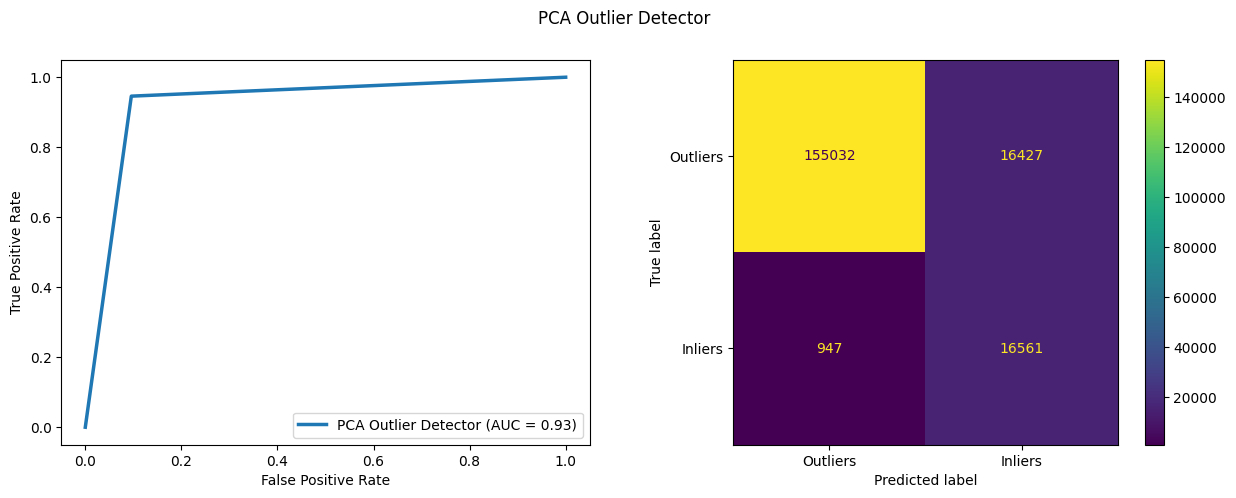

In [ ]:
cm_roc_plot(y_test, y_test_pca, model_name)

The model achieves high F1-scores for both the validation and test sets. Most of the samples are correctly classified, with an AUC ROC score on the test set of ~0.96. The duration of the training phase is the lowest among all the analysed methods.

### Isolation Forest

The Isolation Forest algorithm is one of the classical methods to perform anomaly detection. This technique uses random binary trees to recursively split the data samples considering their local densities, and low density points are classified as anomalous.

Since the partitioning of the samples can be represented by a tree structure, the path length from the root node to one leaf is used as decision function, and points positioned in leaves with short path lengths are defined as outliers.

In [ ]:
model_name = 'Isolation Forest'
model_names_list.append(model_name)
# Values for parameters selection.
params = {
    'n_estimators': [50, 100, 200],
    'max_samples': ['auto', 100, 200, 300],
}

iforest = IsolationForest(contamination=outliers_fraction, random_state=0)

# Find the hyperparameters with maximum F1-score on the validation set.
best_params = find_best_params(iforest, params, X_train, X_val, y_val, model_name)

# Train the model and predict labels for the validation and test sets.
iforest, y_val_if, y_test_if, time_if = sklearn_fit_predict(iforest, X_train, best_params, X_val, X_test, model_name)
y_pred_list.append(y_test_if)
times_list.append(time_if)

Training Isolation Forest
Parameters                                                  F1-score            
{'n_estimators': 50, 'max_samples': 'auto'}                 0.9645614076508555  
{'n_estimators': 50, 'max_samples': 100}                    0.9659035933955681  
{'n_estimators': 50, 'max_samples': 200}                    0.9628858397600367  
{'n_estimators': 50, 'max_samples': 300}                    0.959566740458018   
{'n_estimators': 100, 'max_samples': 'auto'}                0.9637457369125727  
{'n_estimators': 100, 'max_samples': 100}                   0.9540137137353661  
{'n_estimators': 100, 'max_samples': 200}                   0.9630850433809606  
{'n_estimators': 100, 'max_samples': 300}                   0.9572701269596411  
{'n_estimators': 200, 'max_samples': 'auto'}                0.9634097818497438  
{'n_estimators': 200, 'max_samples': 100}                   0.9538322091285778  
{'n_estimators': 200, 'max_samples': 200}                   0.963170300908217   
{'

In [ ]:
# Print the metrics for the validation set.
metric_print(y_val, y_val_if)

Accuracy: 0.9413812993803151
Precision: 0.9928641581527415
Recall: 0.9413812993803151
F1-score: 0.9659035933955681


In [ ]:
# Print the metrics for the test set.
metric_print(y_test, y_test_if)

Accuracy: 0.8495716183248927
Precision: 0.9245161439296372
Recall: 0.8495716183248927
F1-score: 0.873967439773454


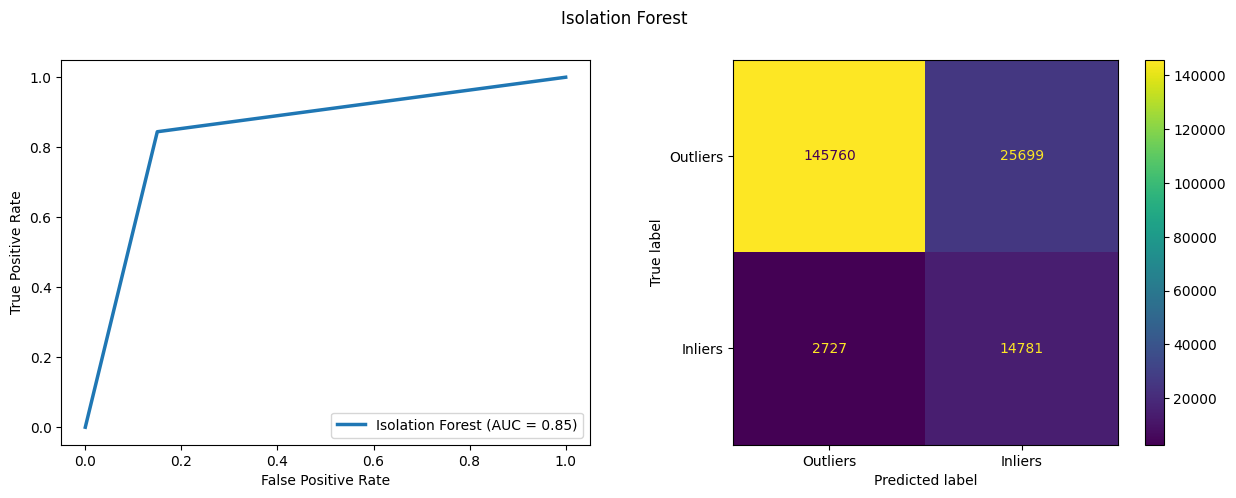

In [ ]:
# Plot and display ROC curve and confusion matrix.
cm_roc_plot(y_test, y_test_if, model_name)

As shown by the ROC curve plot, isolation forest performances result not optimal on the test samples, with an AUC ROC score of ~0.85. The True Positive Rate (recall) is ~0.84, so only the 84% of the true outliers has been classified as anomalies.

### One-Class SVM

As the Isolation Forest, One-Class SVM is one of the classical ML algorithm to perform outlier detection. This method is similiar to the classical SVM (that separate two classes using an hyperplane with the large possible margin), but it uses an hypersphere to encompass all the inliers with the smallest possible radius.

The original sklearn implementation of One-Class SVM has a quadratic complexity, so we decided to use the approximated sklearn method that exploits the Stochastic Gradient Descent (SGD) and has linear complexity. To use the kernelized version of the algorithm, we created a pipeline that transforms the samples to a Gaussian RBF kernel (using the Nystroem approximation) before the actual One-Class SVM classifier.

In [ ]:
model_name = 'One-Class SVM'
model_names_list.append(model_name)
# Values for parameters selection.
params = {
    'nystroem__gamma': [1.0, 2.0, 5.0],
    'sgdoneclasssvm__tol': [1e-3, 1e-4],
}

# We will use a SGD-based One-Class SVM, which allows a faster training than its classical counterpart.
# The rbf kernel used by the normal version of the model is approximated using the Nystroem method.
nystroem = Nystroem(random_state=0)
sgdoneclasssvm = SGDOneClassSVM(random_state=0, nu=outliers_fraction)
# The final model is built as a pipeline, to perform the kernel transformation before the SGD-based One-Class SVM.
ocsvm = make_pipeline(nystroem, sgdoneclasssvm)

# Find the hyperparameters with maximum F1-score on the validation set.
best_params = find_best_params(ocsvm, params, X_train, X_val, y_val, model_name)

# Train the model and predict labels for the validation and test sets.
ocsvm, y_val_ocsvm, y_test_ocsvm, time_ocsvm = sklearn_fit_predict(ocsvm, X_train, best_params, X_val, X_test, model_name)

Training One-Class SVM
Parameters                                                  F1-score            
{'nystroem__gamma': 1.0, 'sgdoneclasssvm__tol': 0.001}      0.94331513997834    
{'nystroem__gamma': 1.0, 'sgdoneclasssvm__tol': 0.0001}     0.94331513997834    
{'nystroem__gamma': 2.0, 'sgdoneclasssvm__tol': 0.001}      0.9431281583973511  
{'nystroem__gamma': 2.0, 'sgdoneclasssvm__tol': 0.0001}     0.9431281583973511  
{'nystroem__gamma': 5.0, 'sgdoneclasssvm__tol': 0.001}      0.9372588472135464  
{'nystroem__gamma': 5.0, 'sgdoneclasssvm__tol': 0.0001}     0.9372588472135464  
Best parameters: {'nystroem__gamma': 1.0, 'sgdoneclasssvm__tol': 0.001}
Training One-Class SVM with parameters {'nystroem__gamma': 1.0, 'sgdoneclasssvm__tol': 0.001}
Training completed in 4.713184833526611 seconds


In [ ]:
# Print the metrics for the validation set.
metric_print(y_val, y_val_ocsvm)

Accuracy: 0.8997867352500701
Precision: 0.9914624736245569
Recall: 0.8997867352500701
F1-score: 0.94331513997834


In [ ]:
# Print the metrics for the test set.
metric_print(y_test, y_test_ocsvm)

Accuracy: 0.09398466398895045
Precision: 0.500530910396471
Recall: 0.09398466398895045
F1-score: 0.031351441655793046


The selected model maximizes the F1-score on the validation samples, but performances drop when predicting labels for the test set. We will now manually set the model parameters to improve the model accuracy.

In [ ]:
# We now manually set the parameters to defined values, trying to increase the model performances.
best_params = {'nystroem__gamma': 5.0, 'sgdoneclasssvm__tol': 1e-3}

# Train the model and predict labels for the validation and test sets.
ocsvm, y_val_ocsvm, y_test_ocsvm, time_ocsvm = sklearn_fit_predict(ocsvm, X_train, best_params, X_val, X_test, model_name)
y_pred_list.append(y_test_ocsvm)
times_list.append(time_ocsvm)

Training One-Class SVM with parameters {'nystroem__gamma': 5.0, 'sgdoneclasssvm__tol': 0.001}
Training completed in 3.69313645362854 seconds


In [ ]:
# Print the metrics for the validation set.
metric_print(y_val, y_val_ocsvm)

Accuracy: 0.8888377335725285
Precision: 0.9945276574434491
Recall: 0.8888377335725285
F1-score: 0.9372588472135464


In [ ]:
# Print the metrics for the test set.
metric_print(y_test, y_test_ocsvm)

Accuracy: 0.9167103250832156
Precision: 0.9422040649944405
Recall: 0.9167103250832156
F1-score: 0.9250825802031788


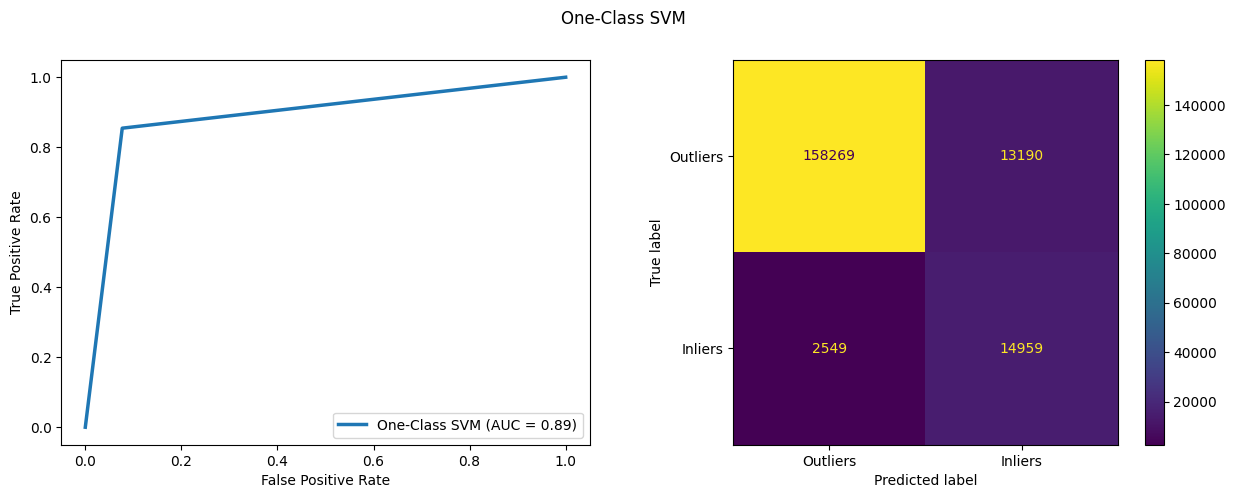

In [ ]:
# Plot and display ROC curve and confusion matrix.
cm_roc_plot(y_test, y_test_ocsvm, model_name)

The algorithm requires a training time similiar to Isolation Forest, but it has better performances on the test set, achieving an AUC ROC score of ~0.89.
This method achieved a small number of false negatives, but with a relatively large number of false positives.


### Autoencoder

An Autoencoder is a artificial neural network that learns two different functions: an encoding function to represent inputs with a smaller set of features, and a decoding function to reconstruct the original sample starting from its encoded representation.

In our analysis, we can use Autoencoder's properties to learn a general representation of the inliers and of their reconstruction function, considering their reconstruction loss. During the test samples' evaluation, outliers will be reconstructed with a larger loss than inliers.  

In [ ]:
# This function creates a transformation to normalize and scale the input set of features.
# Each sample is normalized independently before, so that its l2 norm will be equal to one. Then each feature is scaled to range (0,1).
# This transformation allows to increase the model stability and accuracy.
def fit_scaler(X):
  pipeline = Pipeline([('normalizer', Normalizer()),
                      ('scaler', MinMaxScaler())])
  pipeline.fit(X)
  return pipeline

In [ ]:
# Fit the scaler on the inliers of the training set.
scaler = fit_scaler(X_train_inliers)

# Scale the inliers of the training and validation sets, and the entire validation and test sets.
X_train_in_scaled = scaler.transform(X_train_inliers)
X_val_in_scaled = scaler.transform(X_val_inliers)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

In [ ]:
# This function builds an autoencoder with defined input size, architecture and activation function.
# The hidden_layers list must contain a palindromic sequence of values, to maximize the model stability.
# The act_function value must be one among 'relu', 'sigmoid' or 'tanh'.
def build_autoencoder(input_size, hidden_layers=[], act_function='relu'):
  autoencoder = keras.Sequential()

  # Check whether the activation function is one among 'relu', 'sigmoid' or 'tanh', and if the hidden layers are balanced.
  assert act_function in ['relu', 'sigmoid', 'tanh'], 'The activation function must be relu, sigmoid or tanh'
  assert hidden_layers == list(reversed(hidden_layers)), 'Encoder/Decoder dimensions must be balanced (e.g. 5, 3, 5)'

  # Input layer.
  autoencoder.add(layers.Input(shape=(input_size,)))

  # Encoding/Decoding layers.
  for dim in hidden_layers:
    autoencoder.add(layers.Dense(dim, activation=act_function))

  # Output layer.
  autoencoder.add(layers.Dense(input_size, activation='sigmoid'))

  #Create the autoencoder, using adam optimization and Mean Squared Error as loss function.
  autoencoder.compile(optimizer='adam', loss='mse')
  return autoencoder

In [ ]:
# Function to train the autoencoder using X_train, while evaluated using X_val.
# Early stopping is performed if the validation loss does not decrease in five epochs.
def autoencoder_fit(model, X_train, X_val, epochs=20, batch_size=256, verbose='auto'):
  print(f'Training Autoencoder with parameters epochs: {epochs}, batch_size: {batch_size}')

  start = time.time()
  model.fit(
    X_train, X_train,
    epochs=epochs,
    batch_size=batch_size,
    shuffle=True,
    verbose=verbose,
    callbacks = [keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, mode="min")],
    validation_data=(X_val, X_val))

  duration = time.time() - start
  print(f'Training completed in {duration} seconds')

  # Return the trained model and the training time
  return model, duration

In [ ]:
model_name = 'Autoencoder'
model_names_list.append(model_name)

# The input dimension is the training set's number of features (7).
input_dim = X_train_in_scaled.shape[1]

# Since the model takes a large amount of training time, a manual exploration of the hyperparameters has been performed.
# Build the autoencoder using only one hidden layer with dimension 5 and relu as activation function.
autoencoder = build_autoencoder(input_dim, hidden_layers=[5], act_function='relu')

# Train the model computing the training time.
autoencoder, time_ae = autoencoder_fit(autoencoder, X_train_in_scaled, X_val_in_scaled, epochs=20)
times_list.append(time_ae)

Training Autoencoder with parameters epochs: 20, batch_size: 256
Epoch 1/20
2977/2977 [==============================] - 17s 4ms/step - loss: 0.0252 - val_loss: 0.0023
Epoch 2/20
2977/2977 [==============================] - 12s 4ms/step - loss: 0.0017 - val_loss: 0.0015
Epoch 3/20
2977/2977 [==============================] - 10s 4ms/step - loss: 0.0013 - val_loss: 0.0011
Epoch 4/20
2977/2977 [==============================] - 10s 3ms/step - loss: 7.0265e-04 - val_loss: 8.8851e-04
Epoch 5/20
2977/2977 [==============================] - 11s 4ms/step - loss: 5.1012e-04 - val_loss: 8.5084e-04
Epoch 6/20
2977/2977 [==============================] - 11s 4ms/step - loss: 4.6032e-04 - val_loss: 8.1277e-04
Epoch 7/20
2977/2977 [==============================] - 11s 4ms/step - loss: 4.2716e-04 - val_loss: 7.4027e-04
Epoch 8/20
2977/2977 [==============================] - 11s 4ms/step - loss: 3.8990e-04 - val_loss: 6.5595e-04
Epoch 9/20
2977/2977 [==============================] - 11s 4ms/step - 

In [ ]:
# The computation for the decision threshold is performed using the training set.
# This threshold is set considering the Mean Absolute Error between the original samples
# and their reconstruction given by the autoencoder.
# Its value has been computed considering inliers the 96% of samples with lower reconstruction loss.
def compute_threshold(model, X_train):
  print('Reconstruction of the (clean) training set')
  X_train_rec = model.predict(X_train)
  # Compute the mean absolute error between features for each sample.
  train_loss = keras.losses.mae(X_train_rec, X_train)
  # Inliers are the 96% with lower error.
  threshold = np.percentile(train_loss, 96)
  return threshold

In [ ]:
# This function maps the input boolean array (Outlier vs Not Outlier) to 1/-1.
def map_results(anomalies):
  ret = pd.Series(anomalies)
  return ret.map(lambda x: 1 if x == False else -1)

In [ ]:
# This function receives the trained autoencoder and the chosen threshold as inputs,
# and then it evaluates the reconstruction errors for the samples in the validation and test sets.
# Label predictions for both sets are returned.
def find_val_test_anomalies(model, X_val, X_test, threshold):
  print('Anomaly detection for the validation set')
  X_val_rec = model.predict(X_val)
  val_loss = keras.losses.mae(X_val_rec, X_val)
  y_val_pred = map_results(val_loss > threshold)

  print('Anomaly detection for the test set')
  X_test_rec = model.predict(X_test)
  test_loss = keras.losses.mae(X_test_rec, X_test)
  y_test_pred = map_results(test_loss > threshold)

  return y_val_pred, y_test_pred

In [ ]:
# Compute the threshold using the clean training set.
threshold = compute_threshold(autoencoder, X_train_in_scaled)
# Predict labels for validation and test sets.
y_val_ae, y_test_ae = find_val_test_anomalies(autoencoder, X_val_scaled, X_test_scaled, threshold)
y_pred_list.append(y_test_ae)

Reconstruction of the (clean) training set
23809/23809 [==============================] - 39s 2ms/step
Anomaly detection for the validation set
5906/5906 [==============================] - 10s 2ms/step
Anomaly detection for the test set
5906/5906 [==============================] - 9s 2ms/step


In [ ]:
# Print the metrics for the validation set.
metric_print(y_val, y_val_ae)

Accuracy: 0.9335174924722306
Precision: 0.994125764124909
Recall: 0.9335174924722306
F1-score: 0.961795167252721


In [ ]:
# Print the metrics for the test set.
metric_print(y_test, y_test_ae)

Accuracy: 0.9185783761185815
Precision: 0.9528727005480121
Recall: 0.9185783761185815
F1-score: 0.9284854962025791


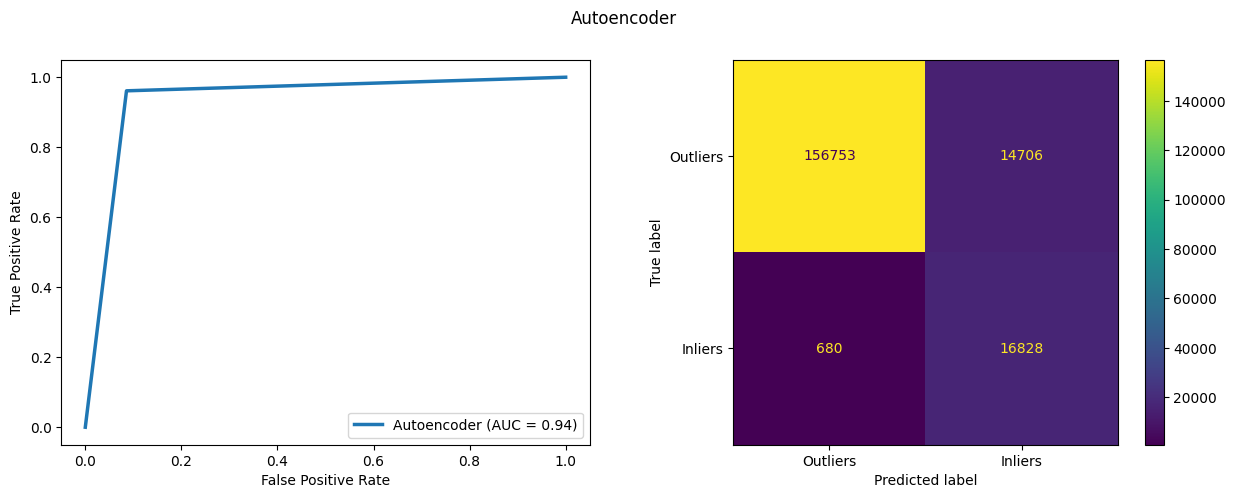

In [ ]:
# Plot and display ROC curve and confusion matrix.
cm_roc_plot(y_test, y_test_ae, model_name)

This anomaly detection method achieves great scores for both the validation and the test sets, as shown by the ROC curve and the confusion matrix.
Since this approach uses a neural network for the classification, both the training and the validation phases require a larger amount of time than most of the other methods.   

## Results

We will now evaluate our analysed methods, showing together their ROC plots and AUC ROC scores, and comparing their required training times.

In [ ]:
def plot_results(model_names_list, y_pred_list, times_list):
  # Input lists must have same size.
  assert len(model_names_list) == len(y_pred_list) == len(times_list), 'Input lists must have same size'

  fig, ax = plt.subplots(1,2, figsize=(18, 5), width_ratios=[1,1.2])
  # Plot ROC curves in a single subfigure.
  for i in range(len(model_names_list)):
    roc = roc_plot(y_test, y_pred_list[i], model_names_list[i])
    roc.plot(ax=ax[0], linewidth=2.5)
  ax[0].plot([0, 1], [0, 1], 'k--', label='Random classifier (AUC = 0.50)', linewidth=2.5)
  ax[0].title.set_text('ROC curves')
  ax[0].legend(loc='lower right')

  # Round times to 2 decimal digits.
  rounded_times = [round(i, 2) for i in times_list]
  # Plot times chart bar in the second subfigure.
  for i in range(len(model_names_list)):
    ax[1].barh(y=model_names_list[i], width=times_list[i])
    if times_list[i] < 1600:
      pos = 30
    else: pos = -200
    ax[1].text(times_list[i]+pos, i, rounded_times[i], va = 'center')
  fig.subplots_adjust(wspace=0.27)
  ax[1].title.set_text('Training time')
  ax[1].set_xlabel('Time (s)')
  plt.show()

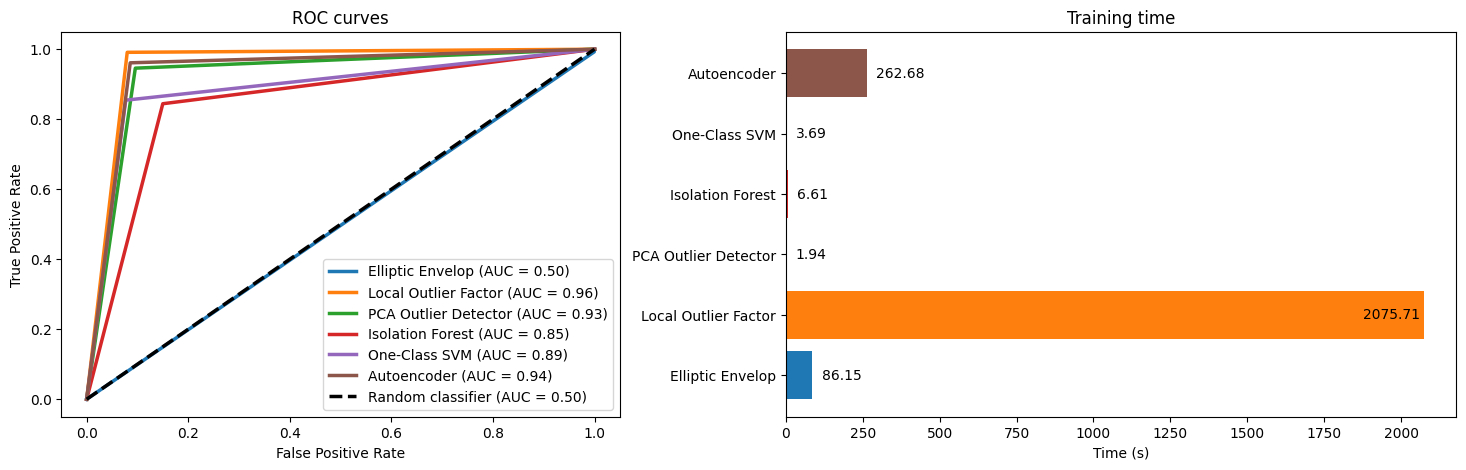

In [ ]:
plot_results(model_names_list, y_pred_list, times_list)

The Elliptic Envelop anomaly detection method achieved the lowest score during our tests, and it results inappropriate for the analysed dataset, because the assumption that data samples has been drawn from a Gaussian distribution is wrong.

Local Outlier Factor method achieved the best score, but its training and evaluation require a large amount of time, due to its complexity and to the dimension of the dataset. This can prove that this approach could be useful to maximize the detecting performances, but it has a very low scalability.

Classical methods such as Isolation Forest and One-Class SVM achieved good performances, with AUC ROC scores respectively of 0.85 and 0.89. However, they produced a relatively large number of false positives and false negatives.


Anomaly detection approaches based on samples reconstruction, such as PCA or Autoencoder, achieved the highest classification scores, and they appear to be the most prominent and effective methods of our analysis.